<a href="https://colab.research.google.com/github/OvinduWijethunge/Machine_Learning_Projects/blob/version-1/youtube%20spam%20classifier/Xgboost%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = 'https://raw.githubusercontent.com/OvinduWijethunge/Machine_Learning_Projects/version-1/youtube%20spam%20classifier/model.csv'
df = pd.read_csv(url)

In [3]:
df.head()

,Unnamed: 0,sim_content,sim_comment,word_count,duplicate_word_ratio,no_of_sentences,length_of_comment,num_of_punctuations,is_period_sequence,stop_word_ratio,post_coment_gap,black_word_count,is_link,is_youtube_link,is_number,comment_duplication,is_spam
0,0,0.265993,0.239773,1.402189,0.000000,1,3.137146,0.0,0,0.0,39.978929,0.200000,0,0,0,0.0,0
1,1,0.327118,0.222346,2.769147,0.000000,1,4.905188,0.0,0,0.0,39.978929,0.000000,0,0,0,0.0,0
2,2,0.433986,0.309582,3.532625,0.032258,1,5.719015,0.0,0,0.0,39.978929,0.064516,0,0,0,0.0,0
3,3,0.201988,0.181141,1.818371,0.000000,1,3.770442,0.0,0,0.0,39.978929,0.000000,0,0,0,0.0,0
4,4,0.176259,0.125743,1.402189,0.000000,1,3.011349,0.0,0,0.0,39.978929,0.000000,0,0,0,0.0,0


In [4]:
df.rename(columns={'Unnamed: 0':'id'},inplace=True)
df.columns

Index(['id', 'sim_content', 'sim_comment', 'word_count',
       'duplicate_word_ratio', 'no_of_sentences', 'length_of_comment',
       'num_of_punctuations', 'is_period_sequence', 'stop_word_ratio',
       'post_coment_gap', 'black_word_count', 'is_link', 'is_youtube_link',
       'is_number', 'comment_duplication', 'is_spam'],
      dtype='object')

#### Standardization  is no need for xgboost

In [5]:
dfc = df.copy()

In [6]:
y = dfc['is_spam']
X = dfc.drop(['is_spam','id'],axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Handle imbalnce dataset (here we gonna use oversampling instead of smotec)

In [8]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os=RandomOverSampler(0.9)
X_train_ns,y_train_ns=os.fit_sample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

X_train = X_train_ns
y_train = y_train_ns

The number of classes before fit Counter({0: 7865, 1: 643})
The number of classes after fit Counter({0: 7865, 1: 7078})


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#### Hyperparameter Tuninng


In [9]:
from xgboost import XGBClassifier

In [10]:
xgb = XGBClassifier()

In [11]:
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [12]:
grid = {
    
    'max_depth':range(3,50),
 'min_child_weight':range(1,20),
 'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

In [13]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [14]:
from sklearn.model_selection import RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',error_score=0,return_train_score=True,verbose=2)

In [15]:
xgb_random.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 27.2min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='bin...
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'ga

#### Evaluvate

In [16]:
best_model = xgb_random.best_estimator_

In [17]:
best_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.3,
              learning_rate=0.1, max_delta_step=0, max_depth=28,
              min_child_weight=2, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [18]:
xgb_random.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.3,
 'max_depth': 28,
 'min_child_weight': 2,
 'reg_alpha': 0.1,
 'subsample': 0.9}

In [19]:
xgb_random.best_score_

0.992705269237485

In [21]:
y_pred = best_model.predict(X_test.values)

In [22]:
err  =(y_pred- y_test)

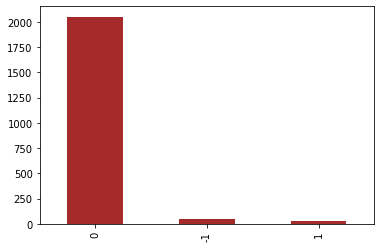

In [23]:
err.value_counts().plot(kind='bar',color='brown')

In [28]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.03620122237893747
MSE: 0.03620122237893747
RMSE: 0.1902661882178162


In [27]:
#indices=list(X_train)
#feat_imp = pd.Series(best_model.feature_importances_, indices).sort_values(ascending=False)
#feat_imp.plot(kind='bar', title='Importance of Features')
#plt.ylabel('Feature Importance Score')

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1929   29]
 [  48  121]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1958
           1       0.81      0.72      0.76       169

    accuracy                           0.96      2127
   macro avg       0.89      0.85      0.87      2127
weighted avg       0.96      0.96      0.96      2127



In [31]:
print("accuracy is {}".format(best_model.score(X_test.values, y_test.values)))

accuracy is 0.9637987776210625


In [ ]:
#import pickle
# open a file, where you ant to store the data
#file = open('random_forest_regression_model_v2.pkl', 'wb')
# dump information to that file
#pickle.dump(rf_random, file)

### ROC

In [32]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [35]:
baseline_roc_auc = roc_auc_score(y_test, best_model.predict(X_test.values))
fprB, tprB, thresholdsB = roc_curve(y_test, best_model.predict_proba(X_test.values)[:,1])

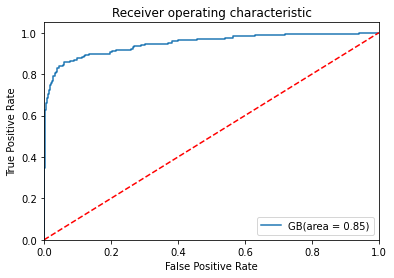

In [36]:
plt.figure()
plt.plot(fprB, tprB, label='GB(area = %0.2f)' % baseline_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()